(16781312, 21)
(16781312,)
(1000, 8192, 21)
(1000, 8192)


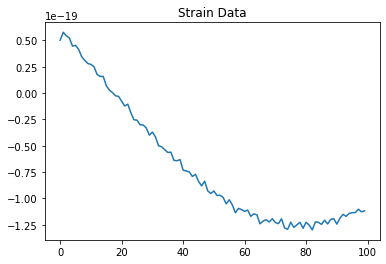

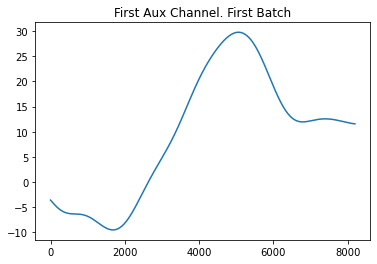

Finding pass-band frequencies via Cross Spectral Density Analysis


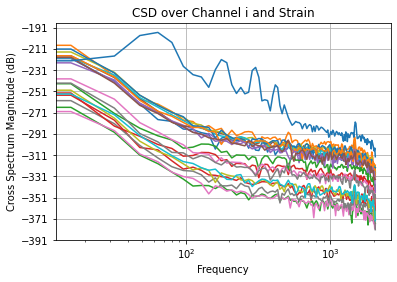

Finding pass-band frequencies via Cross Spectral Density Analysis


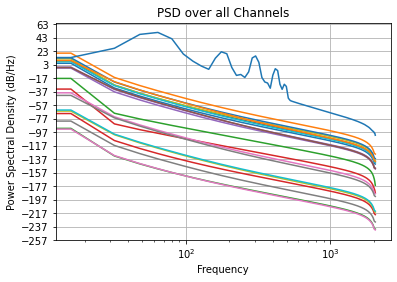

Building Butterworth Filter


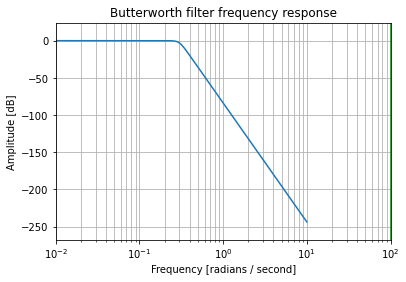

Butterworth filter built
Applying Butterworth to data
(1000, 8192, 21)


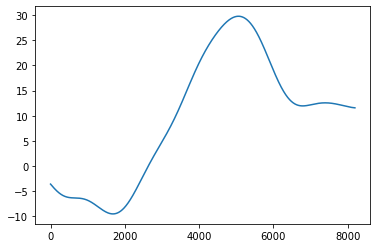

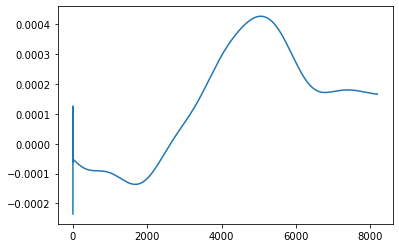

Butterworth filter applied to data
Normalization in progress


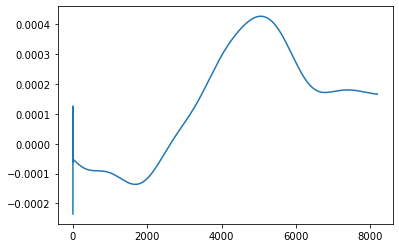

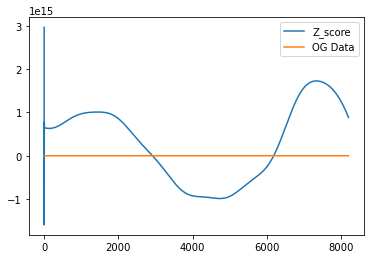

CNN Data Ready, Import witness_data
(1000, 8192, 21)
Normalization Complete
Applying Welch's Method
Welch's Method Complete


In [ ]:
#Import data from preprocessing file
from ipynb.fs.full.data_preprocessing import send_freq_data, send_time_data
from ipynb.fs.full.deep_clean_split import send_train_test
import numpy as np

freq_witness, freq_strain_data = send_freq_data()
time_witness, time_strain_data = send_time_data()
X_train_batch, y_train_batch, X_test_batch, y_test_batch = send_train_test()

print(freq_witness.shape, time_witness.shape, freq_strain_data.shape, time_strain_data.shape)
print(X_train_batch.shape, y_train_batch.shape, X_test_batch.shape, y_test_batch.shape)

# Attempt 6: DeepClean As Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Check input shape, given dataset is sampled at 4096Hz
model = keras.models.Sequential(name="attempt_6")
#Convolution Layers
model.add(layers.Conv1D(filters=21, kernel_size=7, strides=1, padding="same", activation="tanh",\
                        input_shape=(X_train_batch.shape[1], X_train_batch.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=8, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=16, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())

#Deconvolution Layers
model.add(layers.Conv1DTranspose(filters=32, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=16, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=8, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=21, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=1, kernel_size=7, padding="same", name = "output"))

model.summary()

#non-trainable parameters come from the BatchNormalization

In [ ]:
import numpy as np

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.8)

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["accuracy"])

#Fit DeepClean as an Autoencoder, with no train_test_split
results = model.fit(
    X_train_batch,
    y_train_batch,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                keras.callbacks.EarlyStopping(patience=10, verbose=1),
    ],
)

In [ ]:
#model.predict() with full time_witness dataset
noise_predict = model.predict(X_test_batch)
print(noise_predict.shape)

print(noise_predict)

In [ ]:
#noise_predict = np.reshape(noise_predict, (X_test_batch.shape[0]*X_test_batch.shape[1],1))
#print(noise_predict.shape)

In [ ]:
#API Call to send to Postprocessing, WIP
def send_predicted_noise():
    """
    noise_predict = predicted noise from model.predict()
    must be postprocessed before subtracting from 
    time_strain data
    
    time_strain_data = original strain, subtract 
    noise_predict from it once its postprocessed to 
    get clean_data
    """
    return noise_predict, time_strain_data, y_test_batch

# WIP

Tasks:

Modify parameters of interest and measure:
Training time
Validation time
Training loss
Validation loss